In [ ]:
import os
import torch
import gr00t

from gr00t.data.dataset import LeRobotSingleDataset
from gr00t.model.policy import Gr00tPolicy

: 

In [ ]:
# change the following paths
# MODEL_PATH = "nvidia/GR00T-N1.5-3B"
MODEL_PATH = "checkpoints/uav_quadcopter_finetune"

# REPO_PATH is the path of the pip install gr00t repo and one level up
REPO_PATH = os.path.dirname(os.path.dirname(gr00t.__file__))
DATASET_PATH = os.path.join(REPO_PATH, "data/uav.tracking")
EMBODIMENT_TAG = "uav_quadcopter"

device = "cuda" if torch.cuda.is_available() else "cpu"

In [3]:
from gr00t.experiment.data_config import DATA_CONFIG_MAP


data_config = DATA_CONFIG_MAP["uav_quadcopter"]
modality_config = data_config.modality_config()
modality_transform = data_config.transform()

policy = Gr00tPolicy(
    model_path=MODEL_PATH,
    embodiment_tag=EMBODIMENT_TAG,
    modality_config=modality_config,
    modality_transform=modality_transform,
    device=device,
)

# print out the policy model architecture
print(policy.model)

`use_fast` is set to `True` but the image processor class does not have a fast version.  Falling back to the slow version.


Fetching 13 files: 100%|██████████| 13/13 [00:00<00:00, 111733.51it/s]


Loading pretrained dual brain from /root/.cache/huggingface/hub/models--nvidia--GR00T-N1.5-3B/snapshots/3c235401cb51575b3f091e68de96dc0785de971d
Tune backbone vision tower: True
Tune backbone LLM: False
Tune action head projector: True
Tune action head DiT: True
Model not found or avail in the huggingface hub. Loading from local path: /root/.cache/huggingface/hub/models--nvidia--GR00T-N1.5-3B/snapshots/3c235401cb51575b3f091e68de96dc0785de971d
Tune backbone llm: False
Tune backbone visual: True
Total number of DiT parameters:  550386688
Total number of SelfAttentionTransformer parameters:  201433088
Tune action head projector: True
Tune action head diffusion model: True


Loading checkpoint shards: 100%|██████████| 3/3 [00:00<00:00, 11.71it/s]


Tune backbone llm: False
Tune backbone visual: True
Tune action head projector: True
Tune action head diffusion model: True
Policy: Recreating action head with action_horizon 10 (was 16)
Total number of DiT parameters:  550386688
Total number of SelfAttentionTransformer parameters:  201433088
Tune action head projector: True
Tune action head diffusion model: True
GR00T_N1_5(
  (backbone): EagleBackbone(
    (eagle_model): Eagle2_5_VLForConditionalGeneration(
      (vision_model): SiglipVisionModel(
        (vision_model): SiglipVisionTransformer(
          (embeddings): SiglipVisionEmbeddings(
            (patch_embedding): Conv2d(3, 1152, kernel_size=(14, 14), stride=(14, 14), padding=valid)
            (position_embedding): Embedding(256, 1152)
          )
          (encoder): SiglipEncoder(
            (layers): ModuleList(
              (0-26): 27 x SiglipEncoderLayer(
                (layer_norm1): LayerNorm((1152,), eps=1e-06, elementwise_affine=True)
                (self_attn):

In [4]:
import numpy as np

modality_config = policy.modality_config

print(modality_config.keys())

for key, value in modality_config.items():
    if isinstance(value, np.ndarray):
        print(key, value.shape)
    else:
        print(key, value)

dict_keys(['video', 'state', 'action', 'language'])
video delta_indices=[0] modality_keys=['video.front_camera']
state delta_indices=[0] modality_keys=['state.position', 'state.orientation', 'state.velocity', 'state.gimbal']
action delta_indices=[0, 1, 2, 3, 4, 5, 6, 7, 8, 9] modality_keys=['action.flight_control', 'action.velocity_command', 'action.gimbal']
language delta_indices=[0] modality_keys=['annotation.human.task_description']


In [5]:
# Create the dataset
dataset = LeRobotSingleDataset(
    dataset_path=DATASET_PATH,
    modality_configs=modality_config,
    video_backend="decord",
    video_backend_kwargs=None,
    transforms=None,  # We'll handle transforms separately through the policy
    embodiment_tag=EMBODIMENT_TAG,
)

Initialized dataset uav.tracking with uav_quadcopter


In [6]:
import numpy as np

step_data = dataset[0]

print(step_data)

print("\n\n ====================================")
for key, value in step_data.items():
    if isinstance(value, np.ndarray):
        print(key, value.shape)
    else:
        print(key, value)

{'video.front_camera': array([[[[ 0,  0,  0],
         [ 0,  0,  0],
         [ 0,  0,  0],
         ...,
         [ 0,  0,  0],
         [ 0,  1,  1],
         [ 1,  3,  3]],

        [[ 0,  0,  0],
         [ 0,  0,  0],
         [ 0,  0,  0],
         ...,
         [ 0,  0,  0],
         [ 0,  1,  1],
         [ 0,  2,  2]],

        [[ 0,  0,  0],
         [ 0,  0,  0],
         [ 0,  0,  0],
         ...,
         [ 0,  2,  2],
         [ 0,  1,  1],
         [ 0,  0,  0]],

        ...,

        [[ 0,  0,  4],
         [ 0,  0,  4],
         [ 0,  0,  0],
         ...,
         [10,  0,  0],
         [10,  0,  0],
         [10,  0,  0]],

        [[ 0,  0,  4],
         [ 0,  0,  4],
         [ 0,  0,  0],
         ...,
         [10,  0,  0],
         [10,  0,  0],
         [10,  0,  0]],

        [[ 0,  0,  4],
         [ 0,  0,  4],
         [ 0,  0,  0],
         ...,
         [10,  0,  0],
         [10,  0,  0],
         [10,  0,  0]]]], dtype=uint8), 'state.position': array(

In [32]:
import matplotlib.pyplot as plt

traj_id = 0
max_steps = 5000

state_joints_across_time = []
gt_action_joints_across_time = []
images = []

sample_images = 6

for step_count in range(max_steps):
    data_point = dataset.get_step_data(traj_id, step_count)
    state_joints = data_point["state.velocity"][0]
    gt_action_joints = data_point["action.velocity_command"][0]
    
   
    state_joints_across_time.append(state_joints)
    gt_action_joints_across_time.append(gt_action_joints)

    # We can also get the image data
    if step_count % (max_steps // sample_images) == 0:
        image = data_point["video.front_camera"][0]
        images.append(image)

# Size is (max_steps, num_joints == 7)
state_joints_across_time = np.array(state_joints_across_time)
gt_action_joints_across_time = np.array(gt_action_joints_across_time)

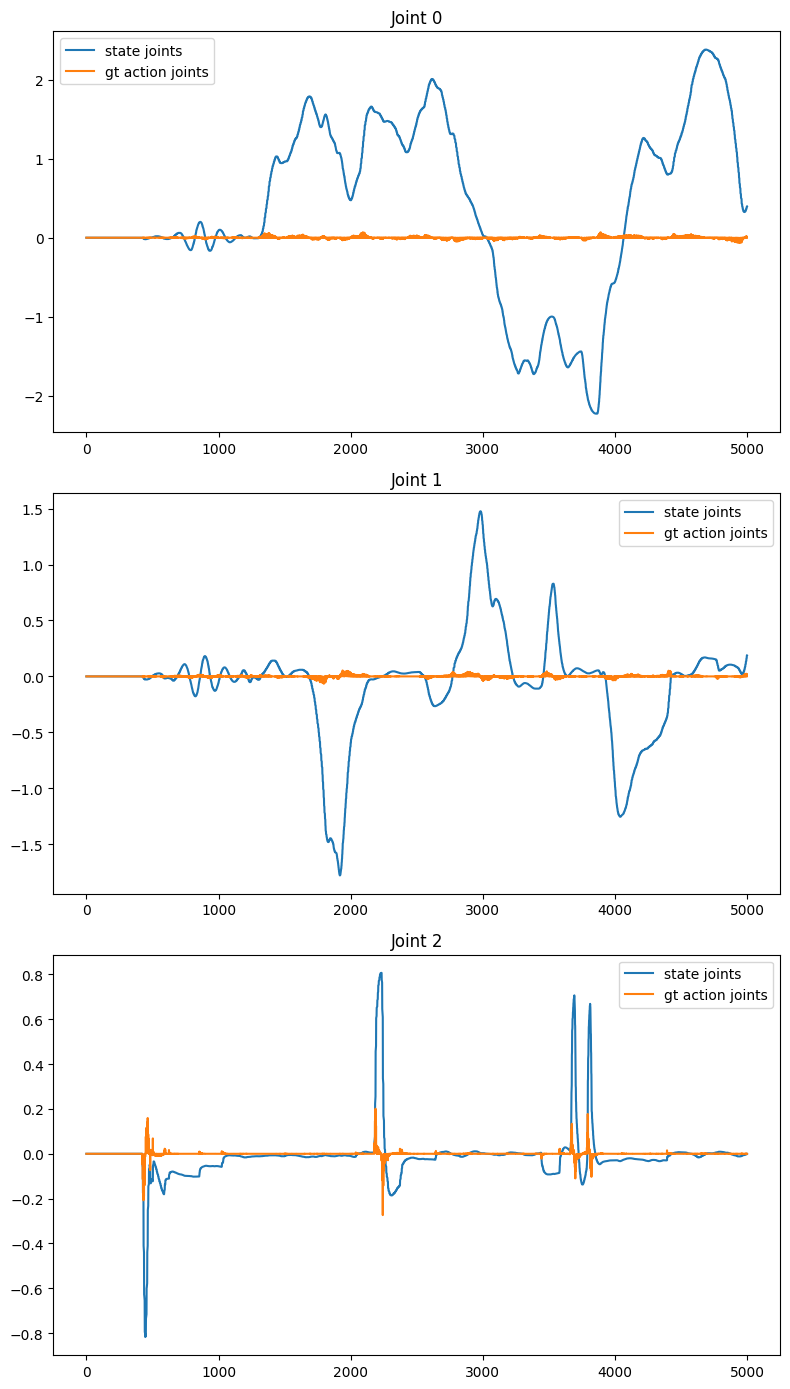

In [33]:
# Plot the joint angles across time
fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(8, 2*7))

for i, ax in enumerate(axes):
    ax.plot(state_joints_across_time[:, i], label="state joints")
    ax.plot(gt_action_joints_across_time[:, i], label="gt action joints")
    ax.set_title(f"Joint {i}")
    ax.legend()

plt.tight_layout()
plt.show()

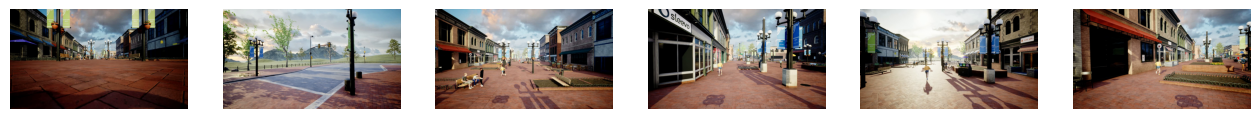

In [34]:
# Plot the images in a row
fig, axes = plt.subplots(nrows=1, ncols=sample_images, figsize=(16, 4))

for i, ax in enumerate(axes):
    ax.imshow(images[i])
    ax.axis("off")

In [36]:
predicted_action = policy.get_action(step_data)
for key, value in predicted_action.items():
    print(key, value.shape)

action.flight_control (10, 4)
action.velocity_command (10, 3)
action.gimbal (10, 3)
